Not Dynamic

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score
import matplotlib.pyplot as plt
import joblib

# Define custom scorer for MAPE
def mape_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Make scorers from custom scoring functions
mape = make_scorer(mape_scorer, greater_is_better=False)

# Load the dataset
df_raw = pd.read_csv('../../Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)

start_of_C = '2015-06-11 20:00:00'
df_period_C = df_raw[df_raw['date_time'] >= start_of_C]

# Extracting non-numeric columns
non_numeric_cols = ['is_holiday', 'weather_type', 'weather_description']

# Group by 'date_time' and aggregate
agg_funcs = {col: 'mean' for col in df_period_C.columns if col not in non_numeric_cols}
agg_funcs.update({col: lambda x: x.mode()[0] if not x.mode().empty else np.nan for col in non_numeric_cols})
df_aggregated = df_period_C.groupby('date_time').agg(agg_funcs)

# One-hot encode categorical features
df = pd.get_dummies(df_aggregated, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Add hour from the 'date_time' column
df['hour'] = df.index.hour


In [2]:
df

,date_time,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,...,weather_description_overcast clouds,weather_description_proximity shower rain,weather_description_proximity thunderstorm,weather_description_scattered clouds,weather_description_sky is clear,weather_description_snow,weather_description_thunderstorm,weather_description_thunderstorm with light rain,weather_description_very heavy rain,hour
date_time,,,,,,,,,,,,,,,,,,,,,
2015-06-11 20:00:00,2015-06-11 20:00:00,282.000000,65.0,3.0,327.0,5.000000,5.000000,287.586,0.0,0.0,...,0,0,0,0,0,0,0,0,0,20
2015-06-12 18:00:00,2015-06-12 18:00:00,84.000000,65.0,3.0,325.0,6.000000,6.000000,297.543,0.0,0.0,...,0,0,0,0,0,0,0,0,0,18
2015-06-12 20:00:00,2015-06-12 20:00:00,97.000000,63.0,3.0,323.0,2.000000,2.000000,292.061,0.0,0.0,...,0,0,0,0,1,0,0,0,0,20
2015-06-12 21:00:00,2015-06-12 21:00:00,29.000000,63.0,2.0,320.0,5.000000,5.000000,292.061,0.0,0.0,...,0,0,0,0,1,0,0,0,0,21
2015-06-13 21:00:00,2015-06-13 21:00:00,78.000000,68.0,3.0,322.0,3.000000,3.000000,294.840,0.0,0.0,...,0,0,0,0,0,0,0,0,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-17 19:00:00,2017-05-17 19:00:00,112.333333,84.0,1.0,321.0,5.000000,5.000000,290.560,0.0,0.0,...,0,0,0,0,0,0,0,0,0,19
2017-05-17 20:00:00,2017-05-17 20:00:00,173.666667,86.0,1.0,326.0,4.000000,4.000000,288.890,0.0,0.0,...,0,0,0,0,0,0,0,0,0,20
2017-05-17 21:00:00,2017-05-17 21:00:00,122.666667,85.0,1.0,328.0,6.666667,6.666667,287.880,0.0,0.0,...,0,0,0,0,0,0,0,0,0,21


In [3]:
# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Split the dataset into features and the target
X = df.drop(target, axis=1)
y = df[target]

# Save 'date_time' for later use
date_time = df['date_time']

# Drop 'date_time' column before scaling
df = df.drop(columns=['date_time'])

# Scale the numerical features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Convert scaled data back to DataFrame and add 'date_time' column back
df_scaled = pd.DataFrame(df_scaled, columns=[col for col in df.columns if col != 'date_time'])
df_scaled['date_time'] = date_time.values

# Split the data into train and test sets
total_samples = df_scaled.shape[0]
split_index = int(total_samples * 0.9)

X_train = df_scaled.iloc[:split_index].drop(columns=['date_time'])
y_train = y.iloc[:split_index]
X_test = df_scaled.iloc[split_index:].drop(columns=['date_time'])
y_test = y.iloc[split_index:]

# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.1, 1, 10]
}

# Update the scoring parameter with a dictionary of metrics
scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'MAPE': mape
}

# Create a TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the GridSearchCV object with the time series cross-validator
grid_search = GridSearchCV(
    estimator=xgboost_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='RMSE',
    cv=tscv,
    verbose=1
)

# Fit the grid search to the scaled data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters_grid = grid_search.best_params_
print(f"Best parameters found with GridSearchCV: {best_parameters_grid}")

# Train the best model on the scaled data
best_model_grid = grid_search.best_estimator_

# Save the best model
joblib.dump(best_model_grid, 'best_cut_C_xgboost_model_gridsearch_v3.joblib')

# Evaluate metrics on the training set
y_train_pred_grid = best_model_grid.predict(X_train)
train_metrics_grid = {
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_grid)),
    'MSE': mean_squared_error(y_train, y_train_pred_grid),
    'MAE': mean_absolute_error(y_train, y_train_pred_grid),
    'MAPE': mape_scorer(y_train, y_train_pred_grid),
    'R2': r2_score(y_train, y_train_pred_grid)
}

# Evaluate metrics on the validation set
y_val_pred_grid = best_model_grid.predict(X_test)
val_metrics_grid = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_val_pred_grid)),
    'MSE': mean_squared_error(y_test, y_val_pred_grid),
    'MAE': mean_absolute_error(y_test, y_val_pred_grid),
    'MAPE': mape_scorer(y_test, y_val_pred_grid),
    'R2': r2_score(y_test, y_val_pred_grid)
}

# Print and compare metrics for GridSearchCV
print("\nMetrics with GridSearchCV:")
print("Training Set Metrics:")
print(train_metrics_grid)
print("\nValidation Set Metrics:")
print(val_metrics_grid)

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
Best parameters found with GridSearchCV: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 10, 'subsample': 0.9}

Metrics with GridSearchCV:
Training Set Metrics:
{'RMSE': 6.876917695831833, 'MSE': 47.29199699524501, 'MAE': 5.395919237990667, 'MAPE': 0.955535404784397, 'R2': 0.9999876432630398}

Validation Set Metrics:
{'RMSE': 13.573440578238031, 'MSE': 184.23828913095878, 'MAE': 7.858747052529623, 'MAPE': 0.35873037439470634, 'R2': 0.9999551579559834}


In [4]:
# Assuming best_model_grid is your trained model
# Plot the first unseen 7 days of validation/test data
unseen_days = 168

# Function to update the lagged features with the new prediction
def update_lagged_features(df, new_prediction, max_lags=3):
    for i in range(max_lags-1, 0, -1):
        df[f'traffic_volume_lag_{i+1}'] = df[f'traffic_volume_lag_{i}']
    df['traffic_volume_lag_1'] = new_prediction

# Generate rolling forecast predictions
predicted_values = []
for i in range(unseen_days):
    current_prediction = best_model_grid.predict(X_test.iloc[i:i+1])[0]
    predicted_values.append(current_prediction)
    if i + 1 < unseen_days:
        update_lagged_features(X_test.iloc[i + 1], current_prediction)

# At this point, 'predicted_values' contains your rolling forecasts
# You can use this for further analysis or plotting


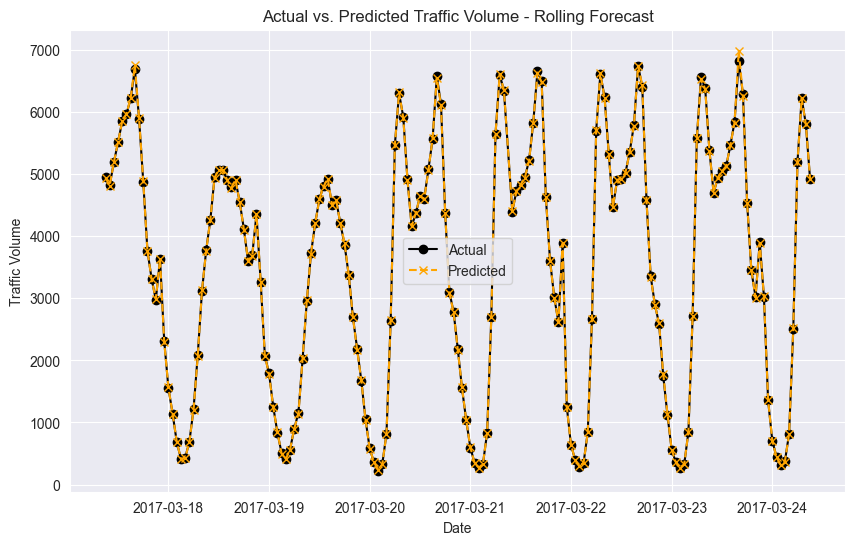

In [5]:
# Create a DataFrame for plotting
plot_df = pd.DataFrame(index=y_test.index[:unseen_days])
plot_df['Actual'] = y_test[:unseen_days].values
plot_df['Predicted'] = predicted_values

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['Actual'], label='Actual', marker='o', linestyle='-', color='black')
plt.plot(plot_df.index, plot_df['Predicted'], label='Predicted', marker='x', linestyle='--', color='orange')
plt.title('Actual vs. Predicted Traffic Volume - Rolling Forecast')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

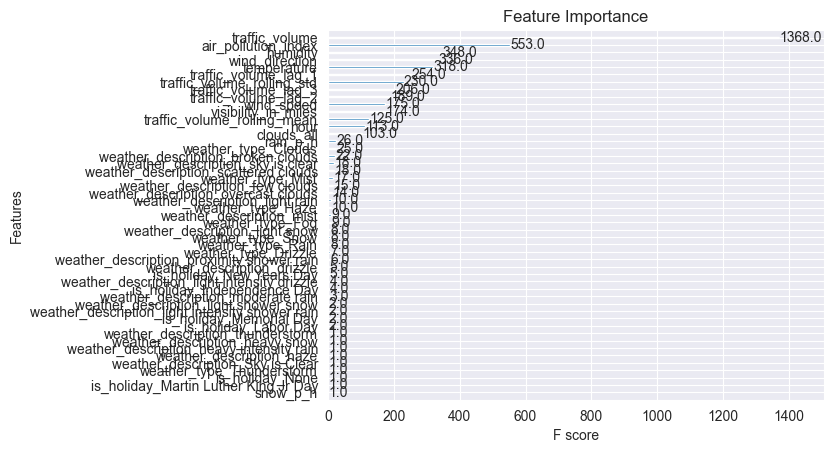

In [6]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming xgboost_model is your trained model
xgboost_model = xgb.XGBRegressor().fit(X_train, y_train)

# Plot feature importance
xgb.plot_importance(xgboost_model)
plt.title("Feature Importance")
plt.show()

In [7]:
# Reset index of original DataFrame and remove any existing 'level_0' column
df.drop(columns=['level_0'], inplace=True, errors='ignore')
df.reset_index(inplace=True)

# Create a new DataFrame for the forecasted values
forecasted_df = pd.DataFrame()
forecasted_df['date_time'] = df.iloc[split_index:]['date_time']
forecasted_df['actual_traffic_volume'] = df.iloc[split_index:]['traffic_volume']
forecasted_df['lag_1'] = df.iloc[split_index:]['traffic_volume_lag_1']
forecasted_df['lag_2'] = df.iloc[split_index:]['traffic_volume_lag_2']
forecasted_df['lag_3'] = df.iloc[split_index:]['traffic_volume_lag_3']

# Predict the traffic volume using the best model for the test set only
forecasted_df['forecasted_traffic_volume'] = best_model_grid.predict(X_test)

# Display the first few rows of the new DataFrame
print(forecasted_df.head())

                date_time  actual_traffic_volume   lag_1   lag_2   lag_3  \
13219 2017-03-17 09:00:00                 4947.0  5538.0  6114.0  4951.0   
13220 2017-03-17 10:00:00                 4822.0  4947.0  5538.0  6114.0   
13221 2017-03-17 11:00:00                 5191.0  4822.0  4947.0  5538.0   
13222 2017-03-17 12:00:00                 5514.0  5191.0  4822.0  4947.0   
13223 2017-03-17 13:00:00                 5857.0  5514.0  5191.0  4822.0   

       forecasted_traffic_volume  
13219                4940.564453  
13220                4812.797852  
13221                5189.999512  
13222                5520.971680  
13223                5852.886230  


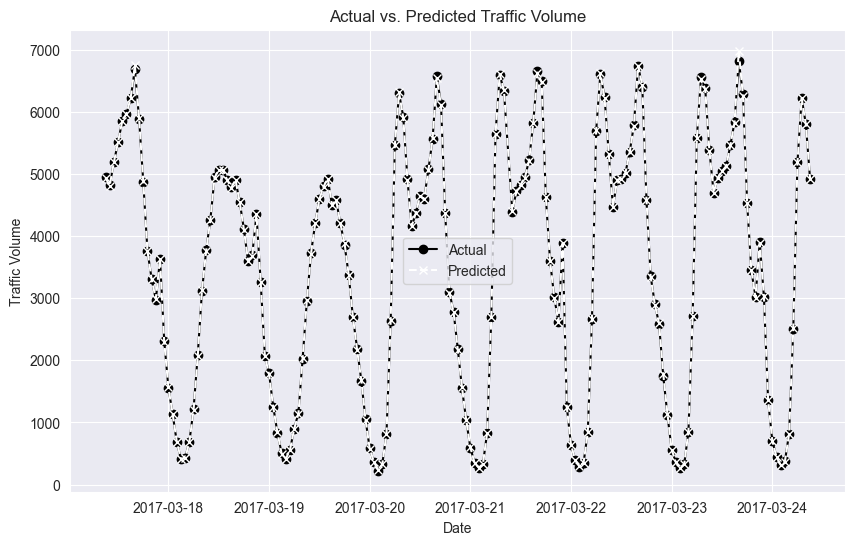

In [8]:
# Plot the first unseen 7 days of validation/test data
unseen_days = 168

# Create a DataFrame with the date_time index for plotting
plot_df = pd.DataFrame(index=y_test.index[:unseen_days])

# Add the actual traffic volume
plot_df['Actual'] = y_test[:unseen_days].values

# Predict traffic volume using the best model
plot_df['Predicted'] = best_model_grid.predict(X_test.iloc[:unseen_days, :])

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['Actual'], label='Actual', marker='o', linestyle='-', color='black')
plt.plot(plot_df.index, plot_df['Predicted'], label='Predicted', marker='x', linestyle='--', color='white')
plt.title('Actual vs. Predicted Traffic Volume')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

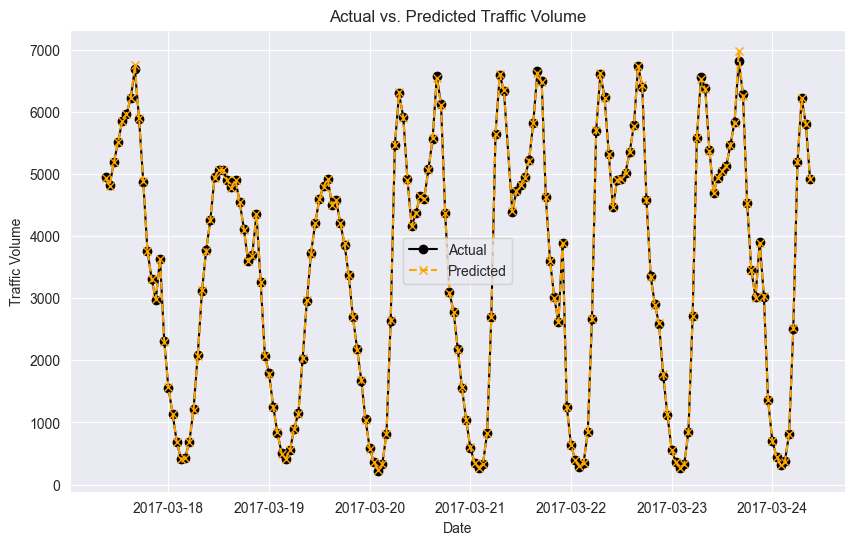

In [9]:
# Plot the first unseen 7 days of validation/test data
unseen_days = 168

# Create a DataFrame with the date_time index for plotting
plot_df = pd.DataFrame(index=y_test.index[:unseen_days])

# Add the actual traffic volume
plot_df['Actual'] = y_test[:unseen_days].values

# Predict traffic volume using the best model
plot_df['Predicted'] = best_model_grid.predict(X_test.iloc[:unseen_days, :])

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['Actual'], label='Actual', marker='o', linestyle='-', color='black')
plt.plot(plot_df.index, plot_df['Predicted'], label='Predicted', marker='x', linestyle='--', color='orange')
plt.title('Actual vs. Predicted Traffic Volume')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()